# <b> SIRAH Candidate Pipeline Demo Notebook</b>
<b>This notebook demostrates how to set up and run the SIRAH candidate pipeline and desribes its basic features</b> <br>
by Mi Dai<br>
April 13, 2020<br>

## **0. prerequisites**

### **0.0 Before you start, follow the instructions under README [here](https://github.com/mi-dai/sirahtargets#pipeline-to-select-sirah-target) to set up conda enviroment and install other required packages**

### **0.1 Credentials**
The following credentials need to be obtained and set up in order to use all functions of the pipeline
- **[alerce]**
- **[lasair]** 
- **[TNS api key]**
- **[SDSS CasJobs]** 
<br>

In the directory of this notebook
`cp -r credentials_template/ credentials/` <br>
Then fill in the credential info for each file.

### **0.2 local GLADE database**
I have converted the downloaded GLADE catalogue into an sqlite3 database for easy query. <br>
For now you can grab the compiled database [here](https://www.dropbox.com/s/aib3ze9vaxmknp7/glade_v23.db?dl=0), and put it into a directory named `db/` in the directory of this notebook <br>
(Later I will make sure the code that generates the db works so that you can make your own)

### **0.3 The following cells set up autoreload and import necessary packages for this notebook**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### **0.4 Define the follow environment variables if you haven't done so**

In [3]:
os.environ['SFD_DIR'] = '/home/mi/sfddata-master' #modify this to point to the dust map downloaded from https://github.com/kbarbary/sfddata
os.environ['SIRAHPIPE_DIR'] = os.getcwd() #Or your sirah_target_pipe dir if you are running in other directories

## **1. Using the pipeline**
### **1.1 import the SIRAHPipe module first**

In [4]:
from pipeline import SIRAHPipe

### **1.2 initialize the pipeline**  <a id='init_pipe'></a>
This cell defines the pipeline and chooses the brokers, crossmatch calalogues, and the selection cuts  <br>
**Currently implemented brokers:** 
[alerce](http://alerce.science/), 
[lasair](https://lasair.roe.ac.uk/streams/#),
[tns](https://wis-tns.weizmann.ac.il/)  <br>
**Crossmatch catalogues:** 
[sdss](https://skyserver.sdss.org/CasJobs/SubmitJob.aspx),
[ned](https://ned.ipac.caltech.edu/forms/nnd.html),
[glade](http://glade.elte.hu/) <br>
**Selection cuts:**
zcut,
ztflimcut,
hostdistcut,
olddetectioncut,
magzcut,
rbcut 
(see <a href='#run_pipe'>1.4 running the pipeline</a> for descriptions on the cuts)<br>
For this demo we select all of the above options:

In [5]:
pipe = SIRAHPipe(brokers=['alerce','lasair','tns'],xmatch_catalogues=['sdss','ned','glade'],
                 selection_cuts=['zcut','ztflimcut','hostdistcut','olddetectioncut','magzcut','rbcut'])

Setting up SkyServer...
Setting up local db [db/glade_v23.db]
Brokers to query: ['alerce', 'lasair', 'tns']
Crossmatch catalogues: ['sdss', 'ned', 'glade']
Cuts to apply: ['zcut', 'ztflimcut', 'hostdistcut', 'olddetectioncut', 'magzcut', 'rbcut']


### **1.3 using the realtime mode**
Let's record current date and time. <br>
The pipeline can run in realtime or non-realtime mode. <br>
if `realtime==True`, the sql query includes conditions on the latest magnitude provided by the brokers; <br>
if `realtime==False`, the latest magnitudes are calculated offline by querying all the detections before the specific date.<br> This is to mimic realtime query but can be used for an earlier date for testing and comparing. Note that this may not produce the exact results as the real time mode as the broker databases may change. <br>
For this demo we set `realtime = True`

In [6]:
from astropy.time import Time
from datetime import datetime
print(Time(datetime.today()),'mjd=',Time(datetime.today()).mjd)
realtime = True

2020-04-22 18:13:58.102328 mjd= 58961.75970026116


### **1.4 running the pipeline** <a id='run_pipe'></a>
This is the main part of the pipeline that many options can be specified. <br>
Here I list some useful ones (and their default values): <br>
- **[query options]** <br>
    - **mjdstart, mjdend:** mjd range to query
    - **gmax(=20.), rmax(=20.), gmin(=16.), rmin(=16.):** max/min magnitude ranges to query (ZTF specifically, for objects on TNS that are not ZTF the bands are hard code to be g at the moment)
    - **qlim:** number of objects to query for brokers (this is a universal number set for all brokers but currently not applied to tns) 
    - **skip_ztf(=True):** set to True to skip importing TNS objects that has internal ZTF names (since it's already in the Alerce/Lasair queries)  
    - **use_sherlock(=True):** include Lasair's sherlock classification and crossmatch results in query, default is True. This can be set to False in case sherlock is not available or for testing purpose
<br>    
- **[selection cut options]** 
    - **[zcut] zlow(=0.016), zhigh(=0.08), zerrlim(=0.02):** limit on redshift and redshift error, for specz the zerr is currently set to 0.001. Increase the number to include photoz results
    - **[magzcut] dmag_min(=1.), dmag_max(=4.5), magabs=(-19.1):** cut on the mag difference from a given absolute magnitude (peak mag for example) - this can be translated as phase cut if the sedmodel is known (see mag/z plot below). 
    - **[rbcut] rb(=0.5):** real/bogus score for ZTF objects (higher rb value is more likely to be real)
    - **[hostdistcut] dist_min(=2.), dist_max(=None):** distance to host (in arcsec) 
    - **[ztflimcut] maglim(=19.8), nobs(=1):** set mag lim for objects that has <= nobs detections. This is used to cut on single detections closer to the (ZTF) limiting mag
    - **[olddetectioncut] dayslim(=5), fromday(=None):** Remove objects whose latest detection is > *dayslim* days from *fromday* (These are potentially too old)
<br>
- **[other options]**
    - **[magz plot options]**
        - **sedmodel=('salt2'):** sedmodel to generate the mag vs z lines. This can be any sncosmo model listed [here](https://sncosmo.readthedocs.io/en/v2.1.x/source-list.html)
        - **sedmodel_pardict=(None):** dictionary of parameters to set for the sedmodel

`pipe.run()` **runs the pipeline and applies the selection cuts defined in <a href='#init_pipe'>1.2 initialize the pipeline</a>, and makes a mag/z plot for the objects that passed all cuts. This may take a while (a few minutes to about less than an hour) depending on how large the query is and how many objects to be crossmatched.**

queryresult size: 100
queryresult size: 100
queryresult size: 166
Table [sncoor] uploaded successfully.
Query Job is submitted. JobID=47354091
Job 47354091 is finished
Cross-matching GLADE catalog using astropy module search_around_sky
Done. Time=0.021483612060546876 minutes
Cross match NED for 0.01 < sdss_photoz < 0.08, num =  2
Table [sncoor] uploaded successfully.
Query Job is submitted. JobID=47354099
Job 47354099 is finished
Cross-matching GLADE catalog using astropy module search_around_sky
Done. Time=0.023793903986612956 minutes
Selecting 0.016 < z < 0.080
 and zerr < 0.010
Number fails cut [flag_zcut]: 779/912
Cut on magnitude lim for nobs <= 1: maglim = 19.8
Number fails cut [flag_ztflimcut]: 14/912
Cut on distance to host: 2 < dist < None (Arcsec)
Number fails cut [flag_hostdistcut]: 113/912
Cut on days since last detection from 2020-04-22 18:16:02.215: dt < 5
Number fails cut [flag_olddetectioncut]: 459/912


/home/mi/ztf/sirah_target_pipe/pipeline.py:166: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.results.fillna(value=pd.np.nan, inplace=True)


Selecting candidates based on mag vs z: 1.00 < dmag (from max) < 4.50
Number fails cut [flag_magzcut]: 784/912
Selecting candidates w/ rb >0.50
queryresult size: 270
Number fails cut [flag_rbcut]: 64/912
Plotting MakeCuts...
Time used: 2.09 mins


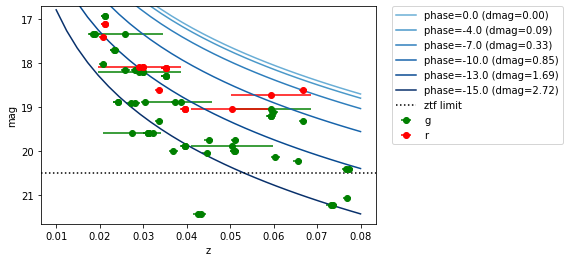

In [7]:
import time
today = Time(datetime.today()).mjd

start = time.time()
pipe.run(mjdstart=today-10,mjdend=today,qlim=100,zerrlim=0.01,dmag_max=4.5,gmax=22,rmax=22,realtime=realtime,skip_ztf=True,use_sherlock=True)
# pipe.run(mjdstart=today-10,mjdend=today,qlim=100,zerrlim=0.01,dmag_max=4.5,gmax=22,rmax=22,realtime=realtime,
#          skip_ztf=True,use_sherlock=True,sedmodel='s11-2005hl',magabs=-18)
end = time.time()
print("Time used: {:.2f} mins".format((end - start)/60.))

### **1.5 Miscellaneous features**
Here I describe some miscellaneous features that may be useful in analyzing the query results

#### 1.5.1  *SIRAHPipe.results*
After the pipeline runs, all the query results, including the selection cut flags, are saved in `SIRAHPipe.results`

In [8]:
pipe.results.head()

,oid,nobs,meanra,meandec,firstmjd,lastmjd,first_magpsf_g,first_magpsf_r,last_magpsf_g,last_magpsf_r,...,xmatch_table_name,flag_zcut,flag_ztflimcut,flag_hostdistcut,flag_olddetectioncut,flag_magzcut,maglim,dmag_g,dmag_r,flag_rbcut
0,ZTF20aaureuj,5,289.611316,40.885027,58953.428519,58956.506215,19.041031,19.072081,19.044121,19.133551,...,NaN,False,True,False,False,False,18.847134,0.196987,0.286417,True
1,ZTF20aaureuj,5,289.611316,40.885027,58953.428519,58956.506215,19.041031,19.072081,19.044121,19.133551,...,NaN,False,True,True,False,False,18.708864,0.335257,0.424687,True
2,ZTF20aauretj,1,261.200259,53.933256,58953.430810,58953.430810,17.448154,NaN,17.448154,NaN,...,NaN,False,True,True,False,False,22.960552,-5.512398,NaN,False
3,ZTF20aauretj,1,261.200259,53.933256,58953.430810,58953.430810,17.448154,NaN,17.448154,NaN,...,NaN,False,True,True,False,False,NaN,NaN,NaN,False
4,ZTF20aauretj,1,261.200259,53.933256,58953.430810,58953.430810,17.448154,NaN,17.448154,NaN,...,NaN,False,True,True,False,False,24.168806,-6.720651,NaN,False


#### 1.5.2 the *SIRAHPipe.MakeCuts* module
- **(re)applying cuts using** ***SIRAHPipe.MakeCuts.[Cutname]*** <br>
The `SIRAHPipe.MakeCuts` module contains all the selection cut functions that can be reapplied after the pipeline runs to change the selection criteria. <br>
e.g. We can reapply the redshift cut with narrower `zerrlim=0.005` or apply new cuts that are not selected in the initialization phase <br>
- **make mag/z plot using** ***SIRAHPipe.MakeCuts.plot()***
- **return a pandas DataFrame for objects that passed all cuts using** ***SIRAHPipe.MakeCuts.aftercuts()*** <br>
Note that `SIRAHPipe.MakeCuts.aftercuts()` returns all entries passing the cuts so there can be multiple entries for the same object. 
You may use `pd.DataFrame.sort_values()` and `pd.DataFrame.drop_duplicates()` to select unique results or define your own ranking

Selecting 0.016 < z < 0.080
 and zerr < 0.005
Selecting candidates based on mag vs z: 0.00 < dmag (from max) < 3.00
Plotting MakeCuts...


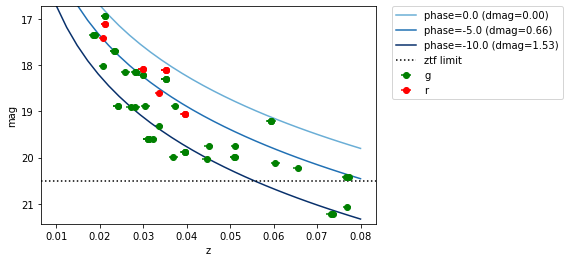

,oid,nobs,firstmjd,lastmjd,gmaglatest,rmaglatest,classearly,classification,distance,separationArcsec,dmag_g,dmag_r,z,zerr,xmatch_rank,objID,xmatch_objid,xmatch_table_name
38,ZTF20aaurfhs,6,58953.437049,58961.458414,18.3010,18.1076,NaN,SN,NaN,3.728834,0.350376,0.156976,0.035225,0.001,1.0,NaN,1237662336799932499,SDSS/PS1/GLADE/2MASS
861,ZTF20aaurjzv,6,58954.394699,58961.433924,19.8709,19.0508,NaN,SN,NaN,8.871231,1.658792,0.838692,0.039605,0.001,1.0,NaN,2MASXJ15335352+5641268,NED/SDSS/PS1/GLADE/2MASS
894,ZTF20aauvjws,5,58954.378044,58961.405961,18.2072,18.0861,NaN,SN,NaN,10.768270,0.620835,0.499735,0.029902,0.001,1.0,NaN,KUG1421+094,NED_D/SDSS/PS1/GLADE/2MASS
412,2020hrx,-99,NaN,58957.574988,18.8890,NaN,NaN,NaN,0.034862,2.091719,1.255786,NaN,0.030540,0.001,NaN,NaN,NaN,NaN
279,2020hwe,-99,NaN,58959.545000,20.2200,NaN,NaN,NaN,0.043190,2.591423,0.872583,NaN,0.065572,0.001,NaN,NaN,NaN,NaN


In [9]:
## apply additional cut here 
pipe.MakeCuts.zcut(zerrlim=0.005)
# pipe.MakeCuts.olddetectioncut()
pipe.MakeCuts.magzcut(dmag_max=3.,dmag_min=0.,magabs=-18)
# pipe.MakeCuts.ztflimcut()
pipe.MakeCuts.plot(magabs=-18,magz_plot=True,sedmodel='snana-2004fe',phase=[-10,-5,0])
# pipe.MakeCuts.plot(magabs=-19,magz_plot=True)
plt.show()
df = pipe.MakeCuts.aftercuts()

cols = ['xmatch_rank','xmatch_db','distance']
sort_cols = [x for x in cols if x in df.columns]
df = df.sort_values(sort_cols).drop_duplicates('oid')
cols = ['oid','nobs','firstmjd','lastmjd','gmaglatest','rmaglatest','classearly','classification','distance','separationArcsec','dmag_g','dmag_r',
   'z','zerr','xmatch_rank','objID','xmatch_objid','xmatch_table_name']
cols_exist = [x for x in cols if x in df.columns]
df[cols_exist].head()

## **2. Making plots for selected candidates**

The main function for making light curve and phase estimate plots is *utils.gen_plots* <br>
`gen_plots()` requires a pandas DataFrame as input that comes from running the pipeline or a self-defined `pd.DataFrame` that has the required columns as the pipeline results <br>
- set **interactive = True** to make interactive plots in jupyter notebook (this doesn't seem to work with jupyter lab) <br>
    if interactive=True, the image will be an interactive Aladin widget; otherwise the image will be retrieved from the PS1 image server
- set **savepdf = True** to out pdfs <br>
    currently the pdfs are plotted in the order of decreasing phase estimation

**Here are some useful *gen_plots* options:** <br>
- **magabs(=-19.1):** For Ia, 
- **extra_lc(=False):** set to *True* is extra photometry is available. The photometry need to be placed in `data/extra_photometry` as `[objectname].txt`
- **update_lc_prediction(=False):** replot the lc prediction
- **last_detection_max(=5):** don't include objects with last detection that is >5 days old
- **source(='ztf'):** provide correct photometry format ('ztf' or 'tns')
- **broker(='alerce'):** for ztf objects only, broker to query for light curve points ('alerce' or 'lasair')
- **plot_ylim(=(21,15)):** ylims for the light curve and mag/z plots
- **ps1_image_size(=320):** image size for PS1 images (in pixels), actual image size is 0.25 arcsec/pixel


ZTF20aaurfhs: z=0.0352 +/- 0.0010
ra = 17:01:22.507 dec = +20:18:58.35 mwebv=0.058


/home/mi/ztf/sirah_target_pipe/utils.py:503: UserWarning: Can only fit SALT2 for ZTF detections
  warnings.warn("Can only fit SALT2 for ZTF detections")
/home/mi/anaconda3/envs/sirah_target/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/home/mi/anaconda3/envs/sirah_target/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


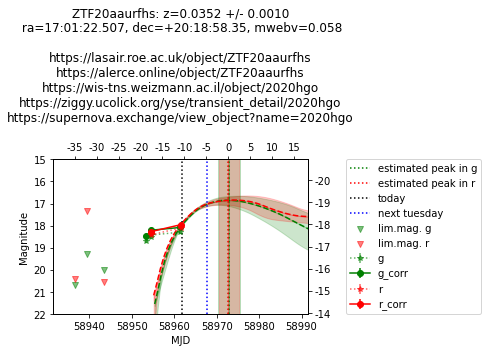

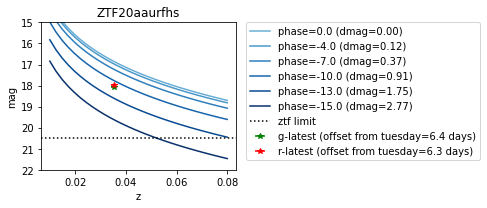

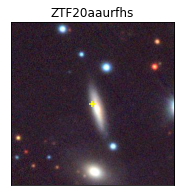

ZTF20aaurjzv: z=0.0396 +/- 0.0010
ra = 15:33:52.438 dec = +56:41:27.72 mwebv=0.014


/home/mi/ztf/sirah_target_pipe/utils.py:503: UserWarning: Can only fit SALT2 for ZTF detections
  warnings.warn("Can only fit SALT2 for ZTF detections")
/home/mi/anaconda3/envs/sirah_target/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/home/mi/anaconda3/envs/sirah_target/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


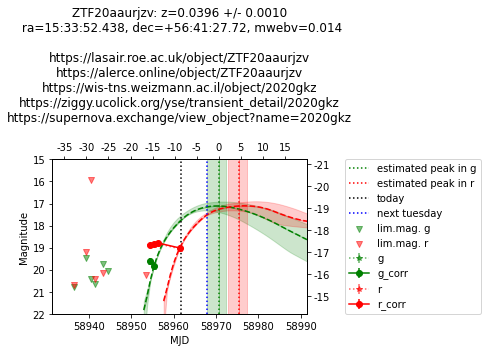

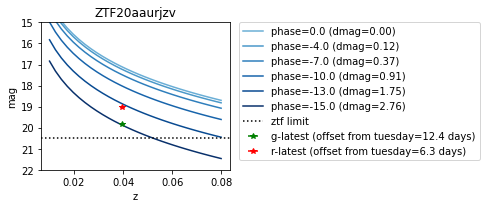

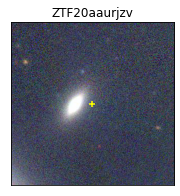

In [10]:
from utils import *
import matplotlib.pyplot as plt
import os
from PyPDF2 import PdfFileMerger
# %matplotlib inline

interactive = False
savepdf = True
querydate = date.today()
if not os.path.isdir('demo'):
    os.mkdir('demo')

if savepdf:
    pdf_file = 'demo/Candidates_{}.pdf'.format(querydate.strftime("%m-%d-%Y"))
    folder = 'demo/{}'.format(querydate.strftime("%m-%d-%Y"))
    if not os.path.isdir(folder):
        os.mkdir(folder)
    pdflist = []
    orderlist = []
# display(target[target.oid=='ZTF20aamfpft'])
for i,row in df[0:2].iterrows():
    if savepdf:
        f = '{}/{}.pdf'.format(folder,row.oid)
    else:
        f = None
    source = 'tns' if row['Broker'] == 'tns' else 'ztf'
    res = gen_plots(row,interactive=interactive,pdf_file=f,source=source,plot_ylim=(22,15),broker='lasair',
                    sedmodel='salt2',magabs=-19.1)
    if savepdf and not res['too_old']:
        pdflist.append(f) 
        orderlist.append(res['phase_tuesday'])
if savepdf:
    idx_ordered = np.argsort(orderlist)
    merger = PdfFileMerger()
    for pdf in np.array(pdflist)[idx_ordered]:
        merger.append(pdf)
    merger.write(pdf_file)
    merger.close()